# Week 1 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [6]:
nlp = spacy.load("en")

In [8]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [9]:
import nltk

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

As mentioned in week 0, I had not decided on the topic of my project yet. I will continue to explore the temporary research question I am considering: "Does the English speaking population show more anger/hatred/negativeness toward China (or Asia) after COVID-19 hit the English-speaking countries (in comparison to when this was more of a local issue in China)?"

For this purpose, I downloaded a set of tweets in March 30th that had COVID-19 related hashtags from [kaggle](https://www.kaggle.com/smid80/coronavirus-covid19-tweets). I will parse tweets that have the word 'China' or 'Chinese' in it for this analysis. I will collect more custom-made data using tweeter API (most likely hydrating a set of tweet IDs) if I decide to stick to this project.

I note that I will be reusing a lot of codes from the original notebook.

First I will load the data and subset only the relevant part of it:

In [110]:
# loading data
tweet_df = pandas.read_csv('../../coronavirus-covid19-tweets/2020-03-30 Coronavirus Tweets.CSV', encoding='utf-8')
# subset to contain only English tweets
tweet_df = tweet_df[tweet_df['lang'] == 'en']
# subset only the columns used for this analysis
tweet_df = tweet_df[['created_at', 'text']].reset_index(drop=True)
# subset tweets that has `China` or `Chinese`
tweet_df = tweet_df[tweet_df['text'].apply(lambda x: ('china' in x.lower()) or ('chinese' in x.lower()))]
# sort by the time it was posted
tweet_df = tweet_df.sort_values('created_at')

Now I will tokenize the text. Note that I modified the function slightly so that I do not include mentions (@-) or links(http-)

In [111]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        # not including metions (@-) or links (http-)
        if not token.is_punct and len(token.text.strip()) > 0 and token.text.strip()[0] != '@' and token.text.strip()[:4] != 'http':
            tokenized.append(token.text)
    return tokenized
# tokenizing the tweets
tweet_df['token_text'] = tweet_df['text'].apply(word_tokenize)
# print for sanity check
tweet_df

,created_at,text,token_text
14,2020-03-30T00:00:00Z,Questions asked about China’s #COVID19 death t...,"[Questions, asked, about, China, ’s, COVID19, ..."
22,2020-03-30T00:00:00Z,#coronavirus mortality rate (with rank in case...,"[coronavirus, mortality, rate, with, rank, in,..."
52,2020-03-30T00:00:02Z,Netherlands 🇳🇱 and Spain 🇪🇸 apparently both re...,"[Netherlands, 🇳, 🇱, and, Spain, 🇪, 🇸, apparent..."
69,2020-03-30T00:00:05Z,The positive effect of our isolation? Look at ...,"[The, positive, effect, of, our, isolation, Lo..."
141,2020-03-30T00:00:17Z,"""For America to defeat the #coronavirus, shoul...","[For, America, to, defeat, the, coronavirus, s..."
...,...,...,...
314303,2020-03-30T23:59:45Z,Stop our critical supplies from being shipped ...,"[Stop, our, critical, supplies, from, being, s..."
314331,2020-03-30T23:59:51Z,Breaking: The US now has twice as many Coronav...,"[Breaking, The, US, now, has, twice, as, many,..."
314332,2020-03-30T23:59:51Z,Everyone gonna die #ChineseVirus #Covid_19 #Co...,"[Everyone, gon, na, die, ChineseVirus, Covid_1..."
314340,2020-03-30T23:59:53Z,There's now a 24hr channel that displays almos...,"[There, 's, now, a, 24hr, channel, that, displ..."


Now I merge all tokenized text into a numpy array. Note that I am not including metions (@-) or links (http-):

In [112]:
tokens = tweet_df['token_text'].sum()
# print first 30 tokens
tokens[:30]

['Questions',
 'asked',
 'about',
 'China',
 '’s',
 'COVID19',
 'death',
 'toll',
 'Locals',
 'in',
 'Wuhan',
 'believe',
 '42,000',
 'people',
 'may',
 'have',
 'died',
 'from',
 'coronavirus',
 'coronavirus',
 'mortality',
 'rate',
 'with',
 'rank',
 'in',
 'cases',
 'for',
 'nations',
 'with',
 'gt;1k']

Counting all the tokens and sorting them by count:

In [113]:
word_counted = wordCounter(tokens)
word_counted.sort_values('count', ascending=False, inplace=True)
word_counted[:10]

,word,count
75,the,13067
3,china,10069
18,coronavirus,8602
80,to,8199
28,of,6232
9,in,5737
61,and,5220
74,is,4558
5,covid19,4376
116,a,4087


We do see that the parsing out relevant tweets worked fine because we see a lot of 'china' and 'coronavirus'. We also see a lot of stopwords like 'the' or 'to' that should be cleaned out in the later process.

Let's first demonstrate the Zipf's law:

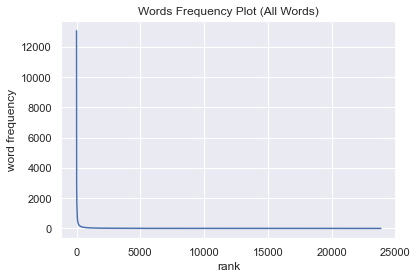

In [114]:
plt.title('Words Frequency Plot (All Words)')
plt.plot(range(word_counted.shape[0]), word_counted['count'])
plt.xlabel('rank')
plt.ylabel('word frequency')
plt.show()

Examining the plot in log-log scale to more clearly see Zipf's law:

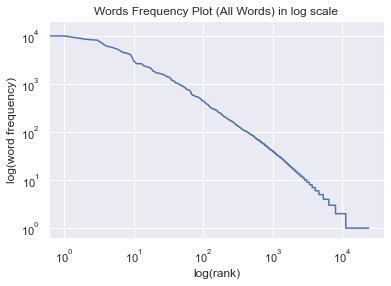

In [115]:
fig, ax = plt.subplots()
ax.plot(range(word_counted.shape[0]), word_counted['count'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('log(rank)')
ax.set_ylabel('log(word frequency)')
ax.set_title('Words Frequency Plot (All Words) in log scale')
plt.show()

Now lets turn the tokens into a nltk `Text` object so we can inspect it in more detail:

In [116]:
covid_Text = nltk.Text(tokens)
covid_CIndex = nltk.text.ConcordanceIndex(covid_Text) 

Let's see some phrases related to some of the keywords.

First `china`:

In [117]:
covid_CIndex.print_concordance('china')

Displaying 25 of 695 matches:
 When Coronavirus Appeared It Failed china is sinister country Something fishy 
orrect We do n’t know how many cases china has but neither does the UnitedState
alkAway Movement coronavirus covid19 china tds journalismisdead timPoolDailySho
alkAway Movement coronavirus covid19 china tds journalismisdead Change in coron
alkAway Movement coronavirus covid19 china tds journalismisdead Hey New York Yo
alkAway Movement coronavirus covid19 china tds journalismisdead I 'm telling my
alkAway Movement coronavirus covid19 china tds journalismisdead t Anyone who th
alkAway Movement coronavirus covid19 china tds journalismisdead t Anyone who th
alkAway Movement coronavirus covid19 china tds journalismisdead Covid19 origina
us what do you think about executing china 😛 corona coronavirus COVID t Anyone 
alkAway Movement coronavirus covid19 china tds journalismisdead If the USA has 
trend Read the thread for more pages china ChinaLiedPeopleDie bioweapon tradewa
 screened 

We can see there is actually a repetition in many instances: 'Movement coronavirus covid19 china tds journalismisdead'. This is likely an group of hashtags that were repeated across tweets. It looks like hashtag might be a good starting place to draw some interesting insights.

Second let's try `wuhan`:

In [118]:
covid_CIndex.print_concordance('wuhan')

Displaying 25 of 46 matches:
 masks found to be defective Chinese wuhan virus tests defective Coronavirus Wu
TC.X $ DXY $ TLT accessory to murder wuhan china chinese bats coronavirus COVID
TC.X $ DXY $ TLT accessory to murder wuhan china chinese bats coronavirus COVID
TC.X $ DXY $ TLT accessory to murder wuhan china chinese bats coronavirus COVID
 CCP CCPchina ChinaVirus coronavirus wuhan If only the Government had acted soo
myself have lost our jobs because of wuhan flu coronavirus F**k china The condi
research on this if any foreigner in wuhan who got infected with Covid_19 and g
old female shrimp seller in china 's wuhan city the originating point of corona
Indexcase(#PatientZero identified in wuhan China 57yr f wrked in wet market 🐃 🐂
onavirus virus riverside viruscorona wuhan instagram instagood viral news busin
onavirus virus riverside viruscorona wuhan instagram instagood viral With no ma
 covid19 martiallaw chinavirus china wuhan virus corona fema trump follow Nothi
steam china

We also see that there is some repetition (probably another set of hashtags).

Let's see if there is any time difference in when the words were mentioned. Note that since I made sorted the tweets in ascending order, the word offset will correspond to the time of the day.

I will look at 3 words directly related to COVID-19 (`coronavirus`, `covid-19`, `virus`), 3 words directly related to China (`china`, `chinese`, `wuhan`), 3 words related to death (`death`, `morbidity`, `rip`) and the leader of China, America and England (`xi`, `trump`, `johnson`)

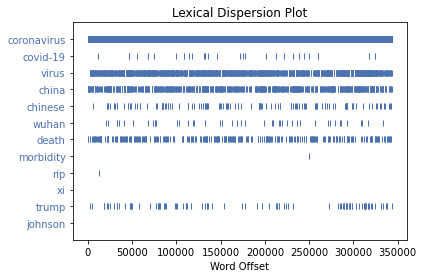

In [119]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
covid_Text.dispersion_plot(['coronavirus', 'covid-19', 'virus',
                            'china', 'chinese', 'wuhan',
                            'death', 'morbidity', 'rip',
                            'xi', 'trump', 'johnson'])
sns.set() #Re-enabling seaborn

We can see that the words are quite evenly distributed within a day. Perhaps if we increase the scope as a month, there might be a difference. Another interesting thing is that while trump (President of United States) are mentioned a lot but not the Xi (General Secretary of the Communist Party of China) are not mentioned at all. Let's look at alternative name for him to see if I am missing something:

In [120]:
print('xi', covid_Text.count('xi'))
print('jin', covid_Text.count('jin'))
print('ping', covid_Text.count('ping'))
print('jinping', covid_Text.count('jinping'))
print('xijinping', covid_Text.count('xijinping'))

xi 0
jin 0
ping 0
jinping 2
xijinping 4


So interestingly, even though these are set of tweets that contain the word 'china' or 'chinese', a national leader of another nation (USA) is mentioned more often thatn the national leader of China. This could potentially be a interesting topic to investigate.

Finally, let's see the distribution of texts to see if there is an interesting phenomenon there:

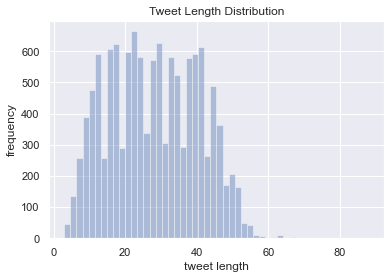

In [121]:
sns.distplot(tweet_df['token_text'].apply(lambda x: len(x)), kde=False)
plt.title('Tweet Length Distribution')
plt.xlabel('tweet length')
plt.ylabel('frequency');

As expected, there seems to be small variation in length, probably related to the ceiling effect coming from twitter's restriction on tweet length.

# Filtering and normalizing text

In [122]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

I will first inspect if there is some stopwords that I should add manually by seeing words that appear more often than `wuhan`

In [123]:
# A little modified to use the dataframe instead of dictionary
stop_words_freq = []

for idx in word_counted.index:
    word = word_counted.loc[idx, 'word']
    if word == 'wuhan':
        break
    # include only the one that is not a stop words
    elif not nlp.vocab[word].is_stop:
        stop_words_freq.append(word)
stop_words_freq

['china',
 'coronavirus',
 'covid19',
 'covid_19',
 'chinese',
 'cases',
 'world',
 'virus',
 'amp',
 'people',
 'chinesevirus',
 'spain',
 'deaths']

I do not really see a word that is not useless in this list except `amp`, which is probably a byproduct of wrong encoding of '&'. Let's see some instances of amp to clarify that:

In [124]:
covid_CIndex.print_concordance('amp')

Displaying 25 of 1398 matches:
charged coronavirus patients in China amp elsewhere are testing positive after 
pporters do n't understand why Canada amp Mexico closed their borders to the US
leDied As China ships ventilators PPE amp medical personnel to Europe and Afric
very Plan ca n't be far behind A Belt amp Road on steroids sealing China 's geo
d ample time to put measures in Place amp Did Nothing BorisJohnson Coronavirus 
 Crimesagainstsociety Communist China amp have lied about Covid_19 since Decemb
19 COVID19 WHO via the United Nations amp DNC pushed CCP propaganda its an invi
nemy in a silent war WE will WIN this amp America amp Americans will be stronge
lent war WE will WIN this amp America amp Americans will be stronger amp more u
merica amp Americans will be stronger amp more united WWG1WGA Will they ever le
ld die of Coronavirus Yes Blame China amp Xi Jinping for the Wuhan CoronavirusP
at Coronavirus Disband The CCP W.H.O. amp W.T.O Today You Helped China Destroy 
ay You He

It makes sense when you replace `amp` with 'and' on the above instances, so I will add the amp for the stop words. Except that, I will normalize and lemmatize with the default setting:

In [131]:
tweet_df['normalized_tokens'] = tweet_df['token_text'].apply(lambda x: normalizeTokens(x, extra_stop=['amp']))
tweet_df['normalized_tokens_count'] = tweet_df['normalized_tokens'].apply(lambda x: len(x))
tweet_df

,created_at,text,token_text,normalized_tokens,normalized_tokens_count
14,2020-03-30T00:00:00Z,Questions asked about China’s #COVID19 death t...,"[Questions, asked, about, China, ’s, COVID19, ...","[question, ask, china, covid19, death, toll, l...",12
22,2020-03-30T00:00:00Z,#coronavirus mortality rate (with rank in case...,"[coronavirus, mortality, rate, with, rank, in,...","[coronavirus, mortality, rate, rank, case, nat...",21
52,2020-03-30T00:00:02Z,Netherlands 🇳🇱 and Spain 🇪🇸 apparently both re...,"[Netherlands, 🇳, 🇱, and, Spain, 🇪, 🇸, apparent...","[netherlands, 🇳, 🇱, spain, 🇪, 🇸, apparently, r...",23
69,2020-03-30T00:00:05Z,The positive effect of our isolation? Look at ...,"[The, positive, effect, of, our, isolation, Lo...","[positive, effect, isolation, look, drop, poll...",19
141,2020-03-30T00:00:17Z,"""For America to defeat the #coronavirus, shoul...","[For, America, to, defeat, the, coronavirus, s...","[america, defeat, coronavirus, identify, china...",13
...,...,...,...,...,...
314303,2020-03-30T23:59:45Z,Stop our critical supplies from being shipped ...,"[Stop, our, critical, supplies, from, being, s...","[stop, critical, supply, ship, china, ⁦@scottm...",16
314331,2020-03-30T23:59:51Z,Breaking: The US now has twice as many Coronav...,"[Breaking, The, US, now, has, twice, as, many,...","[break, twice, coronavirus, case, china, reach...",15
314332,2020-03-30T23:59:51Z,Everyone gonna die #ChineseVirus #Covid_19 #Co...,"[Everyone, gon, na, die, ChineseVirus, Covid_1...","[gon, na, die, chinesevirus, covid_19, coronav...",9
314340,2020-03-30T23:59:53Z,There's now a 24hr channel that displays almos...,"[There, 's, now, a, 24hr, channel, that, displ...","[24hr, channel, display, live, stat, covid19, ...",21


Let's examine the word frequency distribution to see if the Zipf's law still hold on normalized/lemmatized texts:

In [136]:
norm_tokens = tweet_df['normalized_tokens'].sum()
word_counted_norm = wordCounter(norm_tokens)
word_counted_norm.sort_values('count', ascending=False, inplace=True)

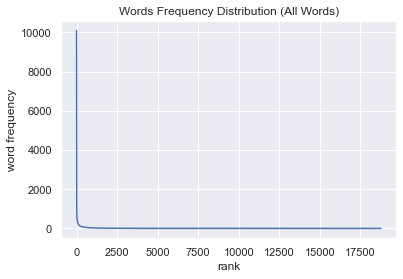

In [139]:
plt.title('Words Frequency Distribution (All Words)')
plt.plot(range(word_counted_norm.shape[0]), word_counted_norm['count'])
plt.xlabel('rank')
plt.ylabel('word frequency')
plt.show()

On log-log scale:

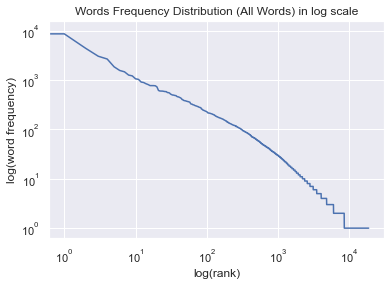

In [140]:
fig, ax = plt.subplots()
plt.plot(range(word_counted_norm.shape[0]), word_counted_norm['count'])
plt.xlabel('rank')
plt.ylabel('word frequency')
plt.show()

Or divide it by the length get a word probability distribution:

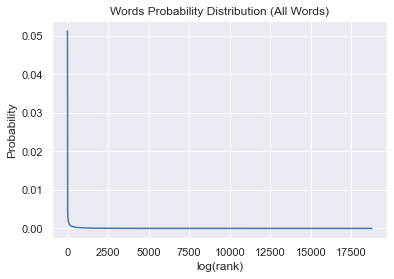

In [143]:
total_words = word_counted_norm['count'].sum()

plt.title('Words Frequency Distribution (All Words)')
plt.plot(range(word_counted_norm.shape[0]), word_counted_norm['count'] / total_words)
plt.xlabel('log(rank)')
plt.ylabel('Probability')
plt.title('Words Probability Distribution (All Words)')
plt.show()

Let's examine top 15 freqeunt words:

In [135]:
word_counted_norm[:15]

,word,count
2,china,10078
11,coronavirus,8607
3,covid19,4379
237,covid_19,3030
162,chinese,2664
15,case,1853
353,world,1561
458,virus,1466
4,death,1259
9,people,1213


This is essentially the list presented above, but we can see that all stopwords had been removed. We see that a lot of words related to COVID-19 (`coronavirus`, `covid19`, `covid19`, `case`, `virus`, `death`, `coronavirustruth`) or China (`china`, `chinese`, `wuhan`) or both (`chinesevirus`) are at the top of the list.

Now lets look at some conditional probabilities. I will use POS tagging for the conditions: since we can see the all the frequent wors are nouns, I am especially curious about adjectives (might be describing the virus/china/chinese, or feeling toward virus/china) and verbs (might be suggesting some action toward virus/china/chinese, etc).

First I will do the POS tagging on the normalized tokens, instead of raw text like in the notebook.

In [144]:
# slightly modified to handle list of tokens too
def spacy_pos(word_list):
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

tweet_df['normalized_tokens_POS'] = tweet_df['normalized_tokens'].apply(lambda x: spacy_pos(x))

I will look at the conditional frequency/probability distribution based on the POS tagging using nltk's `ConditionalFreqDist` and `ConditionalProbDist` class.

In [145]:
cfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in tweet_df['normalized_tokens_POS'].sum())
cpdist_POStoWord = nltk.ConditionalProbDist(cfdist_POStoWord, nltk.ELEProbDist)

Let's look at the conditional frequency distribution for adjectives first:

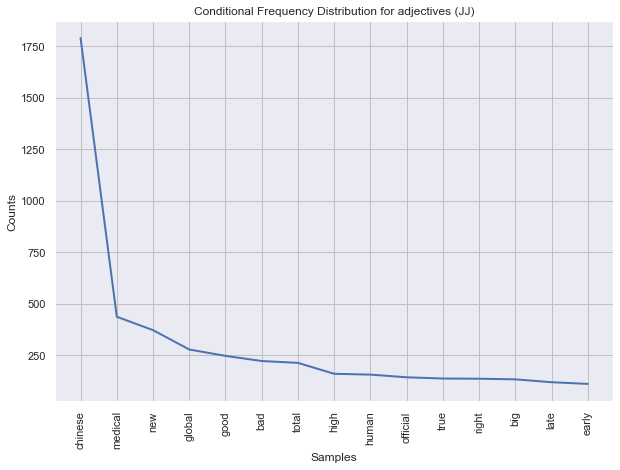

In [184]:
fig = plt.figure(figsize=(10,7))
plt.title('Conditional Frequency Distribution for adjectives (JJ)')
cfdist_POStoWord['JJ'].plot(15);

We can confirm again that we subset the tweets correctly shown by the high frequency of `chineses`. Some adjectives (`medical`, `global`) that seems to be describing the global pandamic are at the top of the list, and a adjective (`official`) that seems to be related to delivering news about the issue are also seen quite often.

Now let's try verbs:

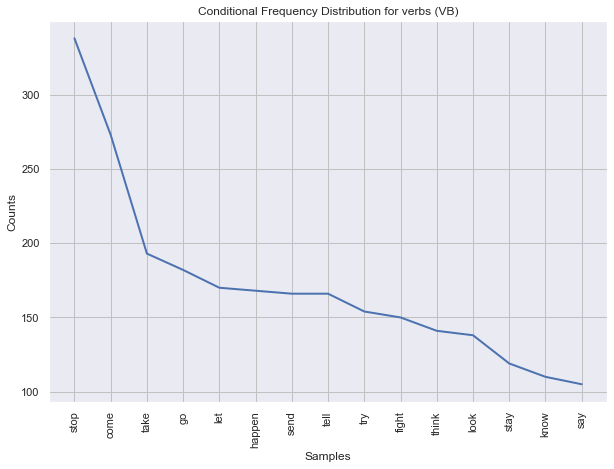

In [185]:
fig = plt.figure(figsize=(10,7))
plt.title('Conditional Frequency Distribution for verbs (VB)')
cfdist_POStoWord['VB'].plot(15);

We see some verbs that are likely related to people trying to respond to the virus (`stop`, `fight`) appearing frequently. Also, `stay` (e.g., "stay home") seems to be related to the social distancing, which is the primary way we are trying to address the issue now.

Now let's plot the conditional probability distribution for adjectives and verbs:

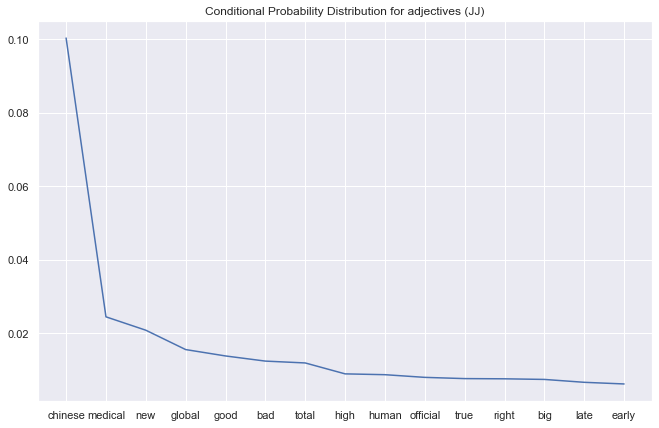

In [186]:
fig = plt.figure(figsize=(11, 7))
plt.plot([word for word, _ in cfdist_POStoWord['JJ'].most_common(15)],
         [cpdist_POStoWord['JJ'].prob(word) for word, _ in cfdist_POStoWord['JJ'].most_common(15)])
plt.title('Conditional Probability Distribution for adjectives (JJ)');

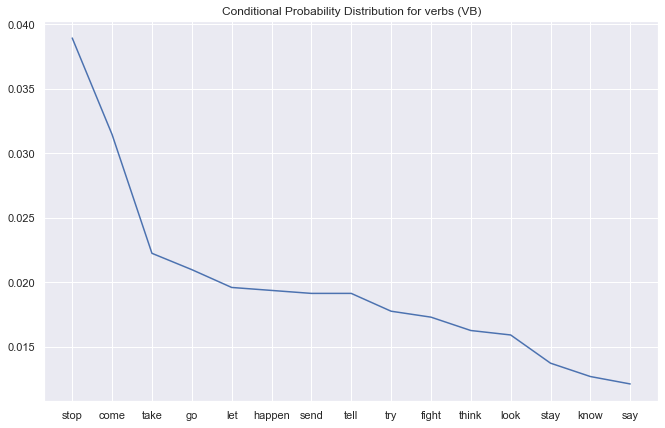

In [187]:
fig = plt.figure(figsize=(11, 7))
plt.plot([word for word, _ in cfdist_POStoWord['VB'].most_common(15)],
         [cpdist_POStoWord['VB'].prob(word) for word, _ in cfdist_POStoWord['VB'].most_common(15)])
plt.title('Conditional Probability Distribution for verbs (VB)');

As we can see, the conditional probability distribution shows same tendency with the conditional frqeuncy distribution.

Finally, let's see the word cloud for the all normalized words:

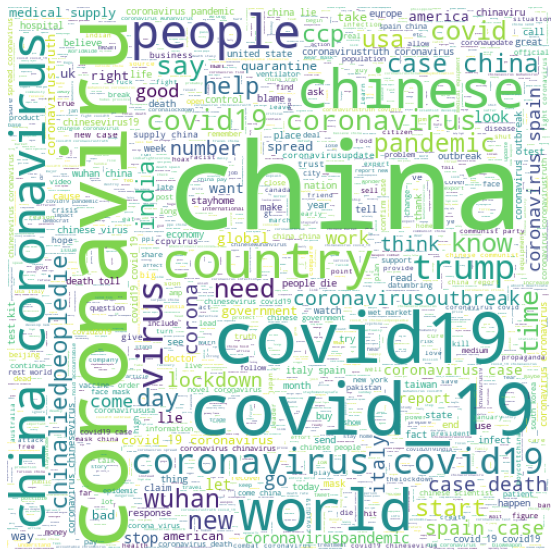

In [197]:
wc = wordcloud.WordCloud(background_color="white", max_words=5000, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(norm_tokens))
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis("off");

One thing about this world cloud is quite clear: COVID-19 and china are the central topic in this corpus. Of course, this should have been expected, since the dataset is a collection of tweets that had hashtag related to COVID-19 and I subsetted the data in a way only tweets that contained words related to China. Another interesting thing is that other countries, such as India, Italy, Spain can be also seen. This suggest that maybe some tweets were deliverying information about the global situation in regard to the pandemic. Importantly, we do see `chinaliedpeopledie` in the wordl. This is likely to be an hashtag, related to the Chinese government. This hashtag seems to be an interesting point to start looking into. Finally, terms like `usa` and `trump` are shown in the wordl - it seems like although we restrict the tweets to be at least mentioning China, there are a lot of tweets mentioning the United States of America. It will be very interesting to look into what is the connection between the two in the twitter space.

# Part-of-Speech (POS) tagging

In [194]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [195]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

I will randomly select 4000 tweets (about 1/3 of the tweets) to use as the corpus for this part.

In [307]:
np.random.seed(0)
FTtweet_df = tweet_df.iloc[np.random.choice(tweet_df.shape[0], 4000), :].copy()

I will sentence tokenize and tag POS for sentences using the functions in the original notebook:

In [201]:
FTtweet_df['sentences'] = FTtweet_df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
FTtweet_df['POS_sents'] = FTtweet_df['sentences'].apply(lambda x: tag_sents_pos(x))

We already have seen the POS tagging on normalized words on the entire dataset above, but let's examine if the tendency for adjectives and verbs is roughly the same with unnormalized text of subset of the dataset.

Let's look at the frequency of adjectives:

In [205]:
countTarget = 'JJ'
targetCounts = {}
for entry in FTtweet_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:15]

[('Chinese', 625),
 ('new', 171),
 ('medical', 146),
 ('other', 133),
 ('many', 102),
 ('global', 67),
 ('last', 62),
 ('first', 61),
 ('COVID-19', 58),
 ('whole', 52),
 ('same', 51),
 ('good', 48),
 ('human', 46),
 ('accountable', 43),
 ('total', 42)]

Again, `chinese` makes the top of the list, alongside adjectives like `medical`, which shows the nature of the tweets that I am seeing right now (a pandemic) and `global`, which also shows that we are talking about global pandemic. Also, it is interesting that `COVID-19` was labeled as an adjective - perhaps we should directly say to spacy that this is a real-world object or a noun.

Now let's look at verbs:

In [212]:
countTarget = 'VB'
targetCounts = {}
for entry in FTtweet_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:15]

[('be', 440),
 ('have', 176),
 ('do', 91),
 ('help', 75),
 ('fight', 70),
 ('take', 63),
 ('stop', 63),
 ('see', 57),
 ('go', 49),
 ('believe', 46),
 ('let', 44),
 ('say', 43),
 ('pay', 43),
 ('know', 43),
 ('spread', 43)]

We see a list of verbs that are not very helpful, like `be`, `have`, `do`, `take`, but we can clearly see that there is a set of verbs that is related to the response to the disease (`help`, `fight`, `stop`) or related to the disease (`spread` and possibily `pay`). This could serve as another illustration on the underlying event that dominates these tweets - COVID-19.

Finally, let's take a look at nouns:

In [213]:
countTarget = 'NN'
targetCounts = {}
for entry in FTtweet_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:15]

[('coronavirus', 703),
 ('COVID19', 436),
 ('world', 425),
 ('Covid_19', 355),
 ('virus', 352),
 ('amp', 299),
 ('country', 149),
 ('lockdown', 141),
 ('time', 130),
 ('pandemic', 122),
 ('government', 111),
 ('🇨', 99),
 ('outbreak', 91),
 ('number', 80),
 ('death', 78)]

The most frequent nouns gives us a rich illustration of the central topic of the tweets again - COVID-19. There are several phrases that directly indexes the disease - `coronavirus`, `COVID19`, `covid_19`, `virus`, `pandemic`, `outbreak`. There are also nouns related to the response to the disease - `lockdown`, `government`. Overall, we can see that the tweets are mostly talking about COVID-19, and possibly some actions taken against it.

Finally, let's see some adjectives and verbs related to China. This part is most related to the potential topic I am exploring - people's thoughts about China after COVDI-19 hit the English-speaking countries.

First I will look at the adjectives:

In [215]:
NTarget = 'JJ'
Word = 'china'
NResults = set()
for entry in FTtweet_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'horrible', 'worried', 'dirty', 'clear', 'communist', 'anti', 'pro', 'fair', 'COVID-19', 'Dear', 'same', 'sudden', 'fast', 'sure', 'wrong', 'southern', 'collateral', 'True', 'funny', '🇹', 'early', 'overseas', 'simple', 'icbedden', 'new', 'safe', 'east', 'central', 'official'}


We could see that there is some sort of negativity bias in the adjectives related to China - `horrible`, `worried`, `dirty` and `COVID-19`. This illustrates that people might be thinking badly about china more negatively. However, we should have some sort of a baseline for good comparison.

Let's look at verbs related to China now. I will change if statement since verb usually follows the noun. Also I will take account of all verb form by only looking at first two characters of `kind2`.

In [230]:
NTarget = 'VB'
Word = 'china'
NResults = set()
for entry in FTtweet_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (ent1.lower(),kind2[:2])==(Word, NTarget):
                NResults.add(ent2)
            else:
                continue

print(NResults)

{'do', 'distributing', 'Covering', 'pays', 'shipped', 'arrived', 'liever', 'sending', 'owes', 'built', 'post', 'launches', 'had', 'destroyed', 'ChinaLiedPeopleDied', 'Does', 'Created', 'gets', 'watching', 'close', 'responding', 'incl', 'manufacturing', 'lie', 'states', 'DID', 'nailed', 'exporting', 'STOP', 'used', 'saves', 'fucked', 'recommends', 'cares', 'passed', 'bars', 'veto', 'worked', 'seems', 'is', 'infected', 'constructed', 'BEING', 'COVID19mexico', 'Imagine', 'bats', 'turned', 'forcing', 'rufused', 'refused', 'locked', 'comes', 'targetted', 'killed', 'lock', 'released', 'building', 'announced', 'faces', 'flexed', 'flooded', 'retail', 'stands', 'says', 'issued', 'lying', 'LIED', 'allowed', 'donates', '’s', 'calls', 'invented', 'cook', 'covid', 'created', 'ronavirus', 'ChinaLiedAndPeopleDied', 'survived', 'needs', 'buying', 'recounts', 'claims', 'uninstall', 'done', 'plans', 'banned', 'expect', 'does', 'sees', 'exported', 'recover', 'shows', 'faced', 'knew', 'tries', 'suggests',

This is a very large data with a lot of neutral verbs, but we could see that verbs like `covering` (covering the death, perhaps), `destroyed`, `lie`, `fucked`, `killed`, `lied` that implies that people are describing the wrongdoings of Chinese government. Of course, more detailed inspection, such as checking the frequency of association, will be needed to draw further conclusion.

# Collocations

In [236]:
def bigramScoring(count, wordsTuple, total):
    return count

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

Let's look at bigrams first:


In [265]:
bigrams = nltk.collocations.BigramCollocationFinder.from_words(norm_tokens)
print("There are {} bigrams in the finder".format(bigrams.N))
print('top 10 most frequent bigrams are:', bigrams.nbest(bigramScoring, 10))

There are 196290 bigrams in the finder
top 10 most frequent bigrams are: [('china', 'coronavirus'), ('coronavirus', 'covid19'), ('covid19', 'coronavirus'), ('case', 'china'), ('coronavirus', 'china'), ('coronavirus', 'spain'), ('case', 'death'), ('spain', 'case'), ('🇨', '🇳'), ('covid19', 'china')]


In [266]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigrams.score_ngrams(bigram_measures.student_t)[:20]

[(('coronavirus', 'covid19'), 17.240944469948346),
 (('🇨', '🇳'), 16.76248796235232),
 (('case', 'death'), 16.48358654840879),
 (('spain', 'case'), 16.43399293727704),
 (('case', 'china'), 15.941221713582532),
 (('covid19', 'coronavirus'), 15.293399170430972),
 (('coronavirus', 'spain'), 14.918337165796896),
 (('medical', 'supply'), 14.771732119506948),
 (('🇺', '🇸'), 12.271977220933662),
 (('italy', 'spain'), 12.124259026036194),
 (('people', 'die'), 11.811521218605124),
 (('death', 'toll'), 11.578854667160526),
 (('united', 'states'), 11.522747805683641),
 (('coronavirus', 'pandemic'), 11.291811409810013),
 (('china', 'lie'), 11.16693210160276),
 (('test', 'kit'), 11.095888648748051),
 (('coronavirustruth', 'coronavirus'), 11.062167346687753),
 (('chinese', 'virus'), 11.031649360556324),
 (('coronavirus', 'outbreak'), 11.011188766185498),
 (('new', 'york'), 10.91106501639621)]

Let's see if any of the above bigrams are idiomatic - for conditional probability, I will simply calculate
$$ \text{number of the particular bigram in corpus} \over \text{number of all bigrams that shares the first word with the particular bigram}$$

In [263]:
def calc_cond_prob(tup, all_bigrams):
    curr_tup_count = tup[1]
    first_word = tup[0][0]
    all_count = 0
    for t in all_bigrams:
        if t[0][0] == first_word:
            all_count += t[1]
    return curr_tup_count / all_count
all_bigrams = bigrams.score_ngrams(bigramScoring)
for tup in all_bigrams[:20]:
    print(tup[0], calc_cond_prob(tup, all_bigrams))

('china', 'coronavirus') 0.07273268505655885
('coronavirus', 'covid19') 0.07226675961426746
('covid19', 'coronavirus') 0.12582781456953643
('case', 'china') 0.22827846735024285
('coronavirus', 'china') 0.04856512141280353
('coronavirus', 'spain') 0.03450679679330777
('case', 'death') 0.15920129519697787
('spain', 'case') 0.3153846153846154
('🇨', '🇳') 0.9155844155844156
('covid19', 'china') 0.058917561087006166
('coronavirus', 'case') 0.026838619728128267
('medical', 'supply') 0.3981981981981982
('covid_19', 'coronavirus') 0.07161716171617162
('china', 'covid19') 0.020539789640801748
('coronavirus', 'pandemic') 0.0219588706866504
('coronavirustruth', 'coronavirus') 0.22446555819477435
('coronavirus', 'covid_19') 0.021029394678749855
('china', 'lie') 0.017265330422702917
('wuhan', 'china') 0.1943820224719101
('covid_19', 'covid19') 0.05577557755775578


We can see that `medical supply` has the highest chance of appearing together, because whenever `medical` was mentioned, there was almost a 40% chance of it being followed by `supply`. However, I do not think it enters the realm of being idiomatic. 

Now trigrams:

In [244]:
trigrams = nltk.collocations.TrigramCollocationFinder.from_words(norm_tokens)
print("There are {} trigrams in the finder".format(trigrams.N))

There are 196290 trigrams in the finder


In [249]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
trigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('spain', 'case', 'china'), 16.646879153677315),
 (('coronavirus', 'spain', 'case'), 16.224893773724514),
 (('case', 'china', 'coronavirus'), 16.146871022196105),
 (('china', '🇨', '🇳'), 11.702462983789946),
 (('medical', 'supply', 'china'), 8.880093408254224),
 (('🇸', 'case', 'death'), 8.364914055185952),
 (('italy', 'spain', 'china'), 8.101654245375473),
 (('chinese', 'communist', 'party'), 7.745644281313654),
 (('🇨', '🇳', 'china'), 7.276513438288392),
 (('chinese', 'scientist', 'develop'), 7.070872250588724),
 (('new', 'weapon', 'combat'), 6.9999487273713745),
 (('develop', 'new', 'weapon'), 6.999945685774762),
 (('spain', '🇪', '🇸'), 6.999881292032099),
 (('weapon', 'combat', 'coronavirus'), 6.999427621900678),
 (('nanomaterial', 'absorb', 'deactivate'), 6.928202646238606),
 (('scientist', 'develop', 'new'), 6.928145464926053),
 (('find', 'nanomaterial', 'absorb'), 6.782327383661363),
 (('italy', '🇮', '🇹'), 6.7822846848523195),
 (('coronavirus', 'coronavirus', 'spain'), 6.750051457

For the quadgrams and 5-grams, I will only report the ones that appeared more than 25 times.

Quadgrams:

In [253]:
quadgrams = nltk.ngrams(norm_tokens, 4)
Counts = {}
for ngram in list(quadgrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
        
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 25:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('believe', 'people', 'die', 'coronavirus'): 27, ('china', 'hold', 'accountable', 'coronavirus'): 39, ('death', 'china', '🇨', '🇳'): 35, ('chinese', 'scientist', 'develop', 'new'): 48, ('scientist', 'develop', 'new', 'weapon'): 47, ('develop', 'new', 'weapon', 'combat'): 49, ('new', 'weapon', 'combat', 'coronavirus'): 48, ('weapon', 'combat', 'coronavirus', 'find'): 42, ('combat', 'coronavirus', 'find', 'nanomaterial'): 42, ('coronavirus', 'find', 'nanomaterial', 'absorb'): 42, ('find', 'nanomaterial', 'absorb', 'deactivate'): 46, ('nanomaterial', 'absorb', 'deactivate', 'virus'): 44, ('absorb', 'deactivate', 'virus', 'efficiency'): 43, ('o', 'originate', 'v', 'virus'): 30, ('originate', 'v', 'virus', 'd'): 29, ('v', 'virus', 'd', 'december'): 29, ('chinesevirus', 'chinesevirus', 'chinesevirus', 'chinesevirus'): 26, ('united', 'states', '🇺', '🇸'): 36, ('states', '🇺', '🇸', 'case'): 34, ('🇺', '🇸', 'case', 'death'): 34, ('🇸', 'case', 'death', 'italy'): 34, ('case', 'death', 'italy', '🇮'):

5-grams:

In [254]:
fivegrams = nltk.ngrams(norm_tokens, 5)
Counts = {}
for ngram in list(fivegrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
        
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 25:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('chinese', 'scientist', 'develop', 'new', 'weapon'): 47, ('scientist', 'develop', 'new', 'weapon', 'combat'): 47, ('develop', 'new', 'weapon', 'combat', 'coronavirus'): 48, ('new', 'weapon', 'combat', 'coronavirus', 'find'): 42, ('weapon', 'combat', 'coronavirus', 'find', 'nanomaterial'): 42, ('combat', 'coronavirus', 'find', 'nanomaterial', 'absorb'): 42, ('coronavirus', 'find', 'nanomaterial', 'absorb', 'deactivate'): 42, ('find', 'nanomaterial', 'absorb', 'deactivate', 'virus'): 44, ('nanomaterial', 'absorb', 'deactivate', 'virus', 'efficiency'): 43, ('o', 'originate', 'v', 'virus', 'd'): 29, ('originate', 'v', 'virus', 'd', 'december'): 29, ('united', 'states', '🇺', '🇸', 'case'): 34, ('states', '🇺', '🇸', 'case', 'death'): 34, ('🇺', '🇸', 'case', 'death', 'italy'): 34, ('🇸', 'case', 'death', 'italy', '🇮'): 34, ('case', 'death', 'italy', '🇮', '🇹'): 34, ('death', 'italy', '🇮', '🇹', 'case'): 34, ('italy', '🇮', '🇹', 'case', 'death'): 34, ('case', 'death', 'china', '🇨', '🇳'): 34, ('deat

Finally for skipgrams (2 words separated by a skip), I will only report the ones that appeared more than 250 times:

In [258]:
skipgrams = nltk.skipgrams(norm_tokens, 2, 2)
Counts = {}
for ngram in list(skipgrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1

Filtered = {}
for key in Counts.keys():
    if Counts[key] < 250:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('china', 'covid19'): 716, ('coronavirus', 'coronavirus'): 490, ('🇨', '🇳'): 298, ('covid19', 'coronavirus'): 837, ('coronavirus', 'china'): 1828, ('covid19', 'china'): 804, ('china', 'coronavirus'): 1888, ('coronavirus', 'covid19'): 934, ('covid_19', 'coronavirus'): 443, ('coronavirus', 'pandemic'): 257, ('case', 'china'): 666, ('china', 'china'): 571, ('coronavirus', 'covid_19'): 370, ('coronavirus', 'chinese'): 397, ('covid_19', 'china'): 568, ('china', 'world'): 342, ('china', 'lie'): 259, ('china', 'covid_19'): 500, ('china', 'virus'): 306, ('case', 'death'): 401, ('chinese', 'coronavirus'): 266, ('wuhan', 'china'): 258, ('china', 'case'): 318, ('coronavirus', 'case'): 648, ('spain', 'coronavirus'): 310, ('world', 'china'): 275, ('chinesevirus', 'coronavirus'): 250, ('coronavirustruth', 'coronavirus'): 302, ('coronavirus', 'chinesevirus'): 291, ('case', 'coronavirus'): 475, ('spain', 'china'): 501, ('coronavirus', 'spain'): 430, ('spain', 'case'): 371}


For the **Stretch**, let's look at words that distinguish `china` and `spain`. I note that I relied harshly on Mint (Poonpatanapritcha) for this part - if this is extra credit, than she should get extra points!

In [274]:
bigram_lst = list(nltk.ngrams(norm_tokens, 2))
china_words = [t[1] for t in bigram_lst if t[0] == 'china']
spain_words = [t[1] for t in bigram_lst if t[0] == 'spain']
china_count = wordCounter(china_words).rename(columns={"word": "word", "count": "china"})
spain_count = wordCounter(spain_words).rename(columns={"word": "word", "count": "spain"})

ttest_df = pandas.merge(china_count, spain_count, on='word', how='outer')
ttest_df.fillna(0, inplace=True)
ttest_df['t'] = abs(ttest_df['china'] - ttest_df['spain'])/((ttest_df['china'] + ttest_df['spain'])**0.5)

In [275]:
ttest_df.sort_values('t', ascending = False)[:10]

,word,china,spain,t
44,coronavirus,733.0,15.0,26.252680
0,covid19,207.0,11.0,13.274795
25,lie,174.0,0.0,13.190906
138,case,57.0,287.0,12.400769
113,covid_19,139.0,4.0,11.289267
319,virus,96.0,0.0,9.797959
2,🇨,137.0,16.0,9.782270
125,pay,65.0,0.0,8.062258
33,wuhan,62.0,1.0,7.685278
66,hold,60.0,1.0,7.554176


We can see that words related to COVID-19, such as `coronavirus`, `covid19`, `covid_19`, `virus` appear more often after China than Spain. On the contrary, `case` is the only thing that appear more often after Spain than China.

I think the fact that word `lie` followed China much more often than Spain could give important insight to my question - this could be a key to the difference in perception toward China in comparision with other countries.

# Named-Entity Recognition

In [277]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

I will reuse the dataframe with 4000 tweets used in exercise 4.

In [278]:
FTtweet_df['classified_sents'] = FTtweet_df['sentences'].apply(lambda x: tag_sents_ner(x))

Let's see what types of entities are most prevalent in the dataset first:

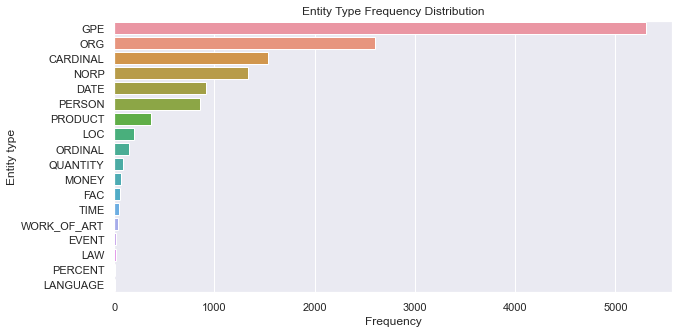

In [286]:
NER_counts = {}
for entry in FTtweet_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind in NER_counts:
                NER_counts[kind] += 1
            else:
                NER_counts[kind] = 1
sorted_NER = sorted(NER_counts.items(), key = lambda x: x[1], reverse = True)
NER_df = pandas.DataFrame(sorted_NER)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(NER_df[1], NER_df[0], ax=ax)
plt.ylabel('Entity type')
plt.xlabel('Frequency')
plt.title('Entity Type Frequency Distribution');

We can see that GPE, or Countries, cities, states, have the highest appearance. This is probably because almost all tweets have the word `china` in it. But Let's make sure that is the case:

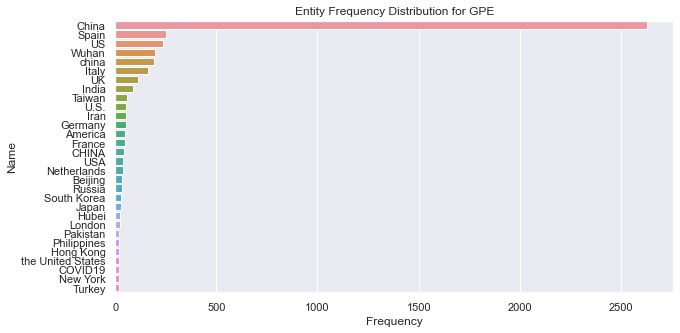

In [289]:
GPE_counts = {}
for entry in FTtweet_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                if ent in GPE_counts:
                    GPE_counts[ent] += 1
                else:
                    GPE_counts[ent] = 1
sorted_GPE = sorted(GPE_counts.items(), key = lambda x: x[1], reverse = True)
GPE_df = pandas.DataFrame(sorted_GPE[:30])

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(GPE_df[1], GPE_df[0], ax=ax)
plt.ylabel('Name')
plt.xlabel('Frequency')
plt.title('Entity Frequency Distribution for GPE');

China being frequently mentioned is the bias I set up in the beginning, so it is not very interesting. Perhaps the more interesting thing is that Spain, US, Italy, and UK is mentioned a lot - maybe there is a group of tweets that delivers the international status of the disease, mentioning a lot of countries. Or maybe there is a relationship between the listed countries and China. More investigation should follow.

Let's see the most frequent entity for ORG(Companies, agencies, institutions, etc), the second most prevalent entity type:

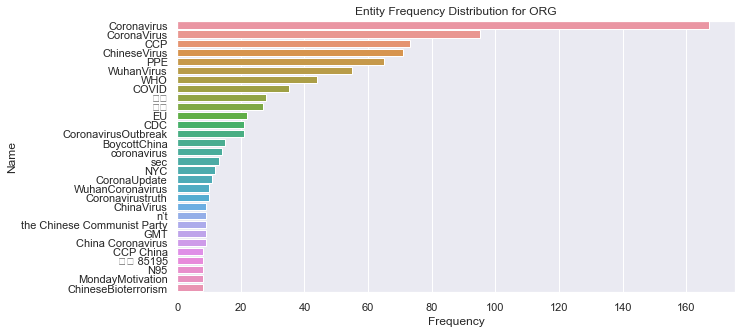

In [291]:
ORG_counts = {}
for entry in FTtweet_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                if ent in ORG_counts:
                    ORG_counts[ent] += 1
                else:
                    ORG_counts[ent] = 1
sorted_ORG = sorted(ORG_counts.items(), key = lambda x: x[1], reverse = True)
ORG_df = pandas.DataFrame(sorted_ORG[:30])

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(ORG_df[1], ORG_df[0], ax=ax)
plt.ylabel('Name')
plt.xlabel('Frequency')
plt.title('Entity Frequency Distribution for ORG');

We can see that the model did a terrible job in NER in this case, because it seems like about 2/3 of words listed here are not organizations. There seems to be a need to train the model so it can correctly classify COVID-19 related words.

As a serendipity, we see that word `ChineseVirus` and `WuhanVirus` is mentioned quite a lot. Since this is likely to be a name for the virus when people explicitly want to blame a country or nation, tracking this might be helpful to understand people's attitude toward China.

For calculating precision, recall and F-score, I will tally `GPE` and only look at 5 tweets because of lack of time.

In [303]:
for i in range(5):
    print('text :', FTtweet_df.iloc[i, 1])
    print('NER :', FTtweet_df.iloc[i, 8])
    print('----')

text : @thehill https://t.co/Q9r7ZOs4x4 I do agree of that! But I can’t understand why US are still being so patience for all the fake news as well as the deceit from China about the #WuhanCoronavirus ? This is humiliation and we hope concrete action should take place. #BlameChina #COVID19 https://t.co/xzpEOYSl6L
NER : [[], [('US', 'GPE'), ('China', 'GPE'), ('WuhanCoronavirus', 'ORG')], [], [('BlameChina', 'ORG')], []]
----
text : #WuhanCoronaVirus #CoronaVirus #ChinaVirus #COVID19 #BatSoup #ChineseVirus
 'Intensive Discussions' At White House Before Trump Decided Not to Quarantine New York https://t.co/B1rZJdK5mm #NewsandPolitics via @pjmedia_com
NER : [[], [('CoronaVirus ChinaVirus', 'ORG')], [], [], [('New York', 'GPE'), ('NewsandPolitics', 'ORG')]]
----
text : All of a sudden China donates medical and protective supplies to which they claim will help fight against #Covid_19 and we start having cases. What a coincidence!
NER : [[('China', 'GPE')], []]
----
text : @HariHaraBhakta @CG

Tweet0:

\+ 2 True Positives (`US` and `China`)

Tweet1:

\+ 1 True Positives (`New York`)

Tweet2:

\+ 1 True Positives (`China`)

Tweet3:

\+ 3 True Positives (`Wuhan`, `China`, `China`)


Tweet4:

\+ 1 True Positives (`US`)

\+ 1 False Positives (`KungFlue`)

---

True Positives = 8

False Positives = 1

False Negatives = 0

---

This leads to

Precision = True Positives / (True Positives + False Positives) = 8 / 9 = .89

Recall = TruePositives / (TruePositives + FalseNegatives) = 8 / 8 = 1.0

F-Score = (2 * Precision * Recall) / (Precision + Recall) = (2 * .89 * 1) / (.89 + 1) = .94

Pretty good score overall! (But we can see that `ORG` classification is quite terrible even looking at 5 tweets)

## Dependency parsing and graph representations

## <span style="color:red">*Exercise 7*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

I will be keep using the dataframe with 4000 tweets used in exercise 4 and 6.

First, I will calculate the average depth of the tree using the function I picked up here: https://gist.github.com/drussellmrichie/47deb429350e2e99ffb3272ab6ab216a

In [306]:
def tree_height(root):
    """
    Find the maximum depth (height) of the dependency parse of a spacy sentence by starting with its root
    Code adapted from https://stackoverflow.com/questions/35920826/how-to-find-height-for-non-binary-tree
    :param root: spacy.tokens.token.Token
    :return: int, maximum height of sentence's dependency parse tree
    """
    if not list(root.children):
        return 1
    else:
        return 1 + max(tree_height(x) for x in root.children)


def get_average_heights(paragraph):
    """
    Computes average height of parse trees for each sentence in paragraph.
    :param paragraph: spacy doc object or str
    :return: float
    """
    if type(paragraph) == str:
        doc = nlp(paragraph)
    else:
        doc = paragraph
    roots = [sent.root for sent in doc.sents]
    return np.mean([tree_height(root) for root in roots])

In [311]:
FTtweet_df['avg_h'] = FTtweet_df['text'].apply(get_average_heights)

Then I will calculate the `flesch_kincaid_reading_ease` value using `spacy-readability` which could give us a rough estimate of readability score:

In [ ]:
from spacy_readability import Readability
nlp.add_pipe(Readability())

In [317]:
def get_flesch_kincaid_reading_ease(text):
    doc = nlp(text)
    return doc._.flesch_kincaid_reading_ease

Let's see if there is any relationship by plotting it!

In [318]:
FTtweet_df['fk_ease'] = FTtweet_df['text'].apply(get_flesch_kincaid_reading_ease)

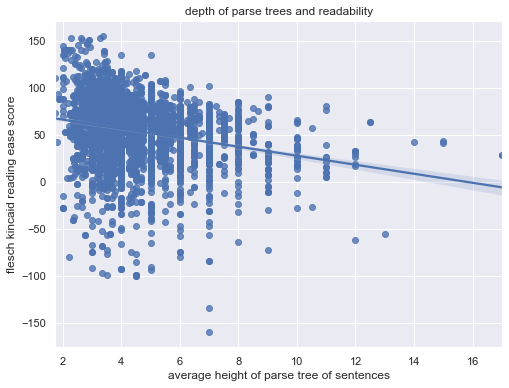

In [325]:
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot('avg_h', 'fk_ease', data=FTtweet_df, ax=ax)
plt.xlabel('average height of parse tree of sentences')
plt.ylabel('flesch kincaid reading ease score')
plt.title('depth of parse trees and readability');

We can see that the text gets a little more harder to read as the depth of the parse tree gets larger. However, this relationship does not seem strong. This is probably because tweets, with their ceiling lenght of 280 characters, might not be an ideal space to look around for complex sentence structure.

Following are the five things I thought would be valuable for subsequent analysis:
* Adjectives that modify a noun (e.g., cooperating person vs lying person)
* Verbs that connects nouns (e.g., I forfeited to him)
* Nouns collocated in a noun phrase (e.g., a surge of anger)
* adverbs that modify a verb (e.g., run rapidly vs run slowly)
* nouns that are roots to other nouns (e.g., The cat owns me)

For this excercise, I will try to inspect a verb that connect nouns, like the demonstration in the original notebook. The first verb I will inspect is `lie` or `lied`.

In [327]:
lie_lst = []
for index, row in FTtweet_df.iterrows():
    text = ' '.join(row['token_text'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        if chunk.root.head.text == 'lie' or chunk.root.head.text == 'lied':
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0 or object_ is not 0:
                lie_lst.append((subject, object_))

In [328]:
lie_lst

[('I', 0),
 ('them', 0),
 ('Party', 0),
 ('China', 0),
 ('they', 0),
 (0, 'coronavirus'),
 ('China', 0),
 (0, 'Spain'),
 ('Trump', 0),
 ('China', 0),
 ('China', 0),
 (0, 'Coronavirus'),
 ('country', 0),
 (0, 'g'),
 ('Party', 0),
 (0, 'what'),
 ('they', 0),
 ('who', 0),
 (0, 'world'),
 ('government', 0),
 ('CCP', 0),
 (0, 'people'),
 ('China', 0),
 ('China', 0),
 ('China', 0),
 (0, 'Covid_19'),
 ('Communists', 0),
 (0, 'silencing'),
 ('China', 0),
 ('dictatorship', 0),
 ('government', 0),
 ('China', 0),
 ('China', 0),
 ('China', 0),
 ('they', 0),
 ('China', 0),
 ('China', 0),
 ('amp', 0),
 ('they', 0),
 ('Party', 0),
 ('Trump', 0),
 ('Party', 0),
 (0, 'what'),
 ('they', 0),
 ('Americans', 0),
 ('China', 0),
 ('they', 0),
 ('Party', 0)]

We can see that people mentions a lot about `China` lying! We see that tweets in this dataset at least consist of some tweets that claims China is lying. It will be interesting to compare if this kind of relationship can be easily found before COVID-19 started to hit the English-speaking countries.

Secondly, let's try `kill` or `killed`.

In [329]:
kill_lst = []
for index, row in FTtweet_df.iterrows():
    text = ' '.join(row['token_text'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        if chunk.root.head.text == 'kill' or chunk.root.head.text == 'killed':
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0 or object_ is not 0:
                kill_lst.append((subject, object_))

In [330]:
kill_lst

[('Flu', 0),
 (0, 'ppl'),
 (0, 'millions'),
 ('Ignorance', 0),
 (0, 'Africa'),
 ('it', 0),
 (0, 'generation'),
 (0, 'Chinese'),
 (0, 'Covid_19'),
 ('who', 0),
 (0, 'citizens'),
 ('they', 0),
 ('ve', 0),
 (0, 'yourself'),
 (0, 'yourself'),
 ('steam', 0),
 (0, 'virus'),
 (0, 'people'),
 (0, 'numbers'),
 ('China', 0),
 (0, 'people'),
 (0, 'coronavirus'),
 ('History', 0),
 ('Communism', 0),
 (0, 'nations'),
 (0, 'us'),
 ('coronavirus', 0),
 (0, 'people'),
 (0, 'patient'),
 ('it', 0),
 (0, 'agents'),
 ('China', 0),
 (0, 'world'),
 ('accident', 0),
 (0, 'thousands'),
 ('ve', 0),
 (0, 'WarCrimes'),
 (0, '🥺'),
 ('they', 0),
 (0, 'coronavirus'),
 (0, 'yourself'),
 (0, 'yourself'),
 ('steam', 0),
 ('coronavirus', 0),
 (0, 'thousands'),
 ('they', 0),
 (0, 'doctors'),
 (0, 'coronavirus'),
 (0, 'people'),
 ('mentality', 0),
 (0, 'us')]

We do see some subject like `flu` or `coronavirus`, which people say the disease killed people, but there are some small instances where subjects are `china` or `communism`. Perhaps people said that the country, not the virus, is responsible for the killing. On the object side, we see some more variation, suggesting this pandemic is killing a lot of entities ranging from `doctors` to `generation`.

# Distributional distances

In [333]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

In [354]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

## <span style="color:red">*Exercise 8*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

For the four corpora, I will use load three more set of tweets from different time - March 12th, 18th, and 24th (recall that the corpora we have been working with was from March 30th). I will randomly subset 1000 tweets from each dataset.

In [379]:
np.random.seed(8)
tweet_df0 = tweet_df.iloc[np.random.choice(tweet_df.shape[0], 1000, replace=False), :]

tweet_df1 = pandas.read_csv('../../coronavirus-covid19-tweets/2020-03-12 Coronavirus Tweets.CSV')
tweet_df1 = tweet_df1[tweet_df1['lang'] == 'en']
tweet_df1 = tweet_df1[['created_at', 'text']].reset_index(drop=True)
tweet_df1 = tweet_df1[tweet_df1['text'].apply(lambda x: ('china' in x.lower()) or ('chinese' in x.lower()))]
tweet_df1 = tweet_df1.sort_values('created_at')
tweet_df1 = tweet_df1.iloc[np.random.choice(tweet_df1.shape[0], 1000, replace=False), :]
tweet_df1['token_text'] = tweet_df1['text'].apply(word_tokenize)
tweet_df1['normalized_tokens'] = tweet_df1['token_text'].apply(lambda x: normalizeTokens(x, extra_stop=['amp']))

tweet_df2 = pandas.read_csv('../../coronavirus-covid19-tweets/2020-03-18 Coronavirus Tweets.CSV')
tweet_df2 = tweet_df2[tweet_df2['lang'] == 'en']
tweet_df2 = tweet_df2[['created_at', 'text']].reset_index(drop=True)
tweet_df2 = tweet_df2[tweet_df2['text'].apply(lambda x: ('china' in x.lower()) or ('chinese' in x.lower()))]
tweet_df2 = tweet_df2.sort_values('created_at')
tweet_df2 = tweet_df2.iloc[np.random.choice(tweet_df2.shape[0], 1000, replace=False), :]
tweet_df2['token_text'] = tweet_df2['text'].apply(word_tokenize)
tweet_df2['normalized_tokens'] = tweet_df2['token_text'].apply(lambda x: normalizeTokens(x, extra_stop=['amp']))

tweet_df3 = pandas.read_csv('../../coronavirus-covid19-tweets/2020-03-24 Coronavirus Tweets.CSV')
tweet_df3 = tweet_df3[tweet_df3['lang'] == 'en']
tweet_df3 = tweet_df3[['created_at', 'text']].reset_index(drop=True)
tweet_df3 = tweet_df3[tweet_df3['text'].apply(lambda x: ('china' in x.lower()) or ('chinese' in x.lower()))]
tweet_df3 = tweet_df3.sort_values('created_at')
tweet_df3 = tweet_df3.iloc[np.random.choice(tweet_df3.shape[0], 1000, replace=False), :]
tweet_df3['token_text'] = tweet_df3['text'].apply(word_tokenize)
tweet_df3['normalized_tokens'] = tweet_df3['token_text'].apply(lambda x: normalizeTokens(x, extra_stop=['amp']))

First let's calculate divergence/distance of the four corpora, draw heatmap and array them in two dimensions with multidimensional scaling using the tokens without normalization (also no stopoword removal).

In [366]:
corpora = []
corpora.append(tweet_df0['token_text'].sum())
corpora.append(tweet_df1['token_text'].sum())
corpora.append(tweet_df2['token_text'].sum())
corpora.append(tweet_df3['token_text'].sum())

In [339]:
fileids = ['2020-03-30', '2020-03-12', '2020-03-18', '2020-03-24']

Kullback-Leibler divergence:

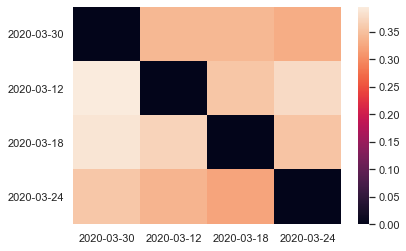

In [371]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


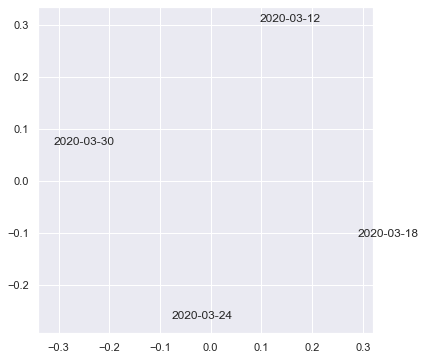

In [372]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

$\chi^2$ Divergence:

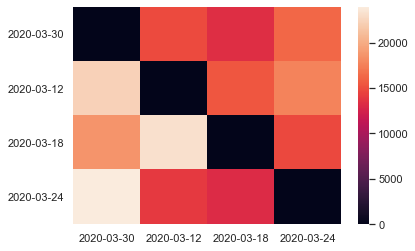

In [373]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


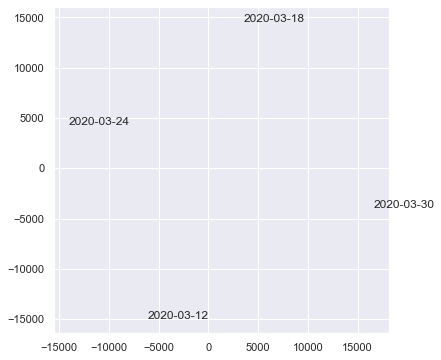

In [374]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Kolmogorov-Smirnov distance:

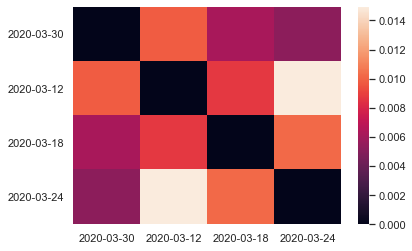

In [375]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


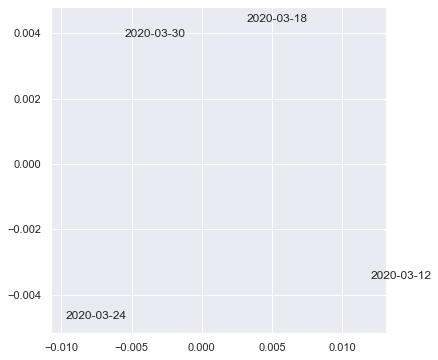

In [376]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Wasserstein distance:

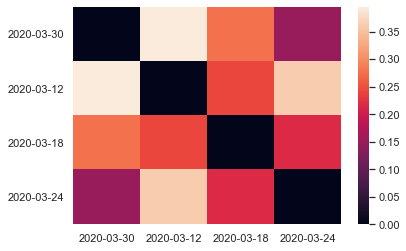

In [377]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


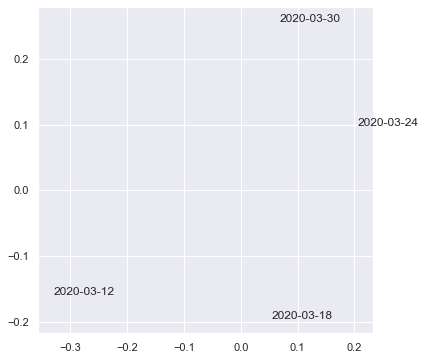

In [378]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

We can see that all analysis (divergence/distance) distinguishes the document quite well. If I have to choose, I will probably use KL divergence with two dimensions with multidimensional scaling, since that seems to be distinguishing the corporas slightly better than others.

Now let's try with normalized tokens.

In [380]:
corpora = []
corpora.append(tweet_df0['normalized_tokens'].sum())
corpora.append(tweet_df1['normalized_tokens'].sum())
corpora.append(tweet_df2['normalized_tokens'].sum())
corpora.append(tweet_df3['normalized_tokens'].sum())

Kullback-Leibler divergence:

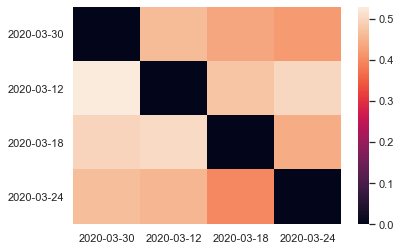

In [381]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


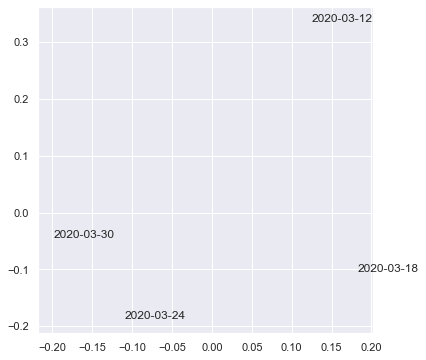

In [385]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

$\chi^2$ Divergence:

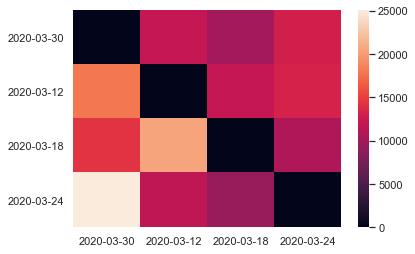

In [382]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


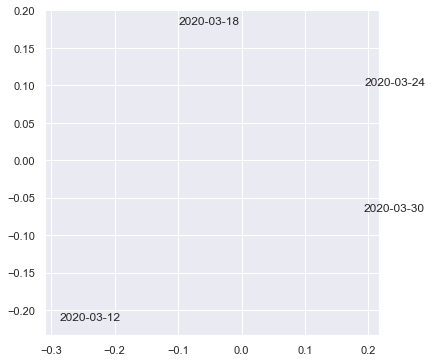

In [386]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Kolmogorov-Smirnov distance:

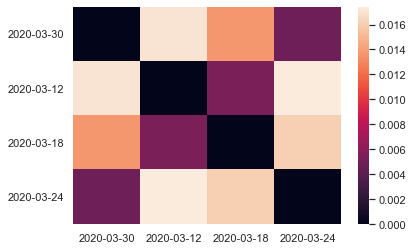

In [383]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


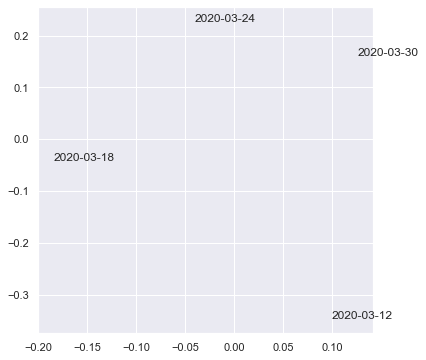

In [387]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Wasserstein distance:

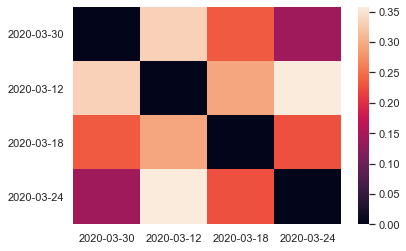

In [384]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


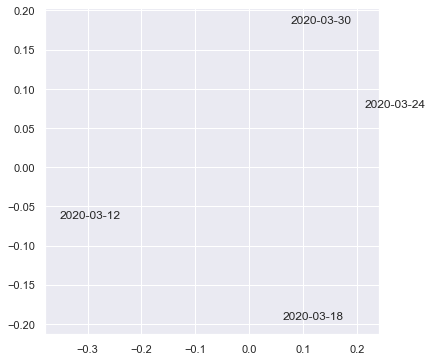

In [388]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Again, all methods and metrics seems to be doing a quite a good job distinguishing the corporas. I think this could be because (1) twitter is a space where the word used are different quite a lot from one day to other, and (2) This is sample (since the original dataset I downloaded is a sample of tweets) of a sample (I subsetted 1000 tweets for this analysis), so the sampling might have differentiatied what was captured and what was not in the corpora. I will have to work on bigger corpora to diminish explanatory power of (2).

Finally, for the **Stretch**, I calculate the Jensen-Shannon Divergence using the not-normalized tokens. Again, I got a lot of help from Mint, so if there is a credit, it should be given to her.

In [391]:
corpora = []
corpora.append(tweet_df0['token_text'].sum())
corpora.append(tweet_df1['token_text'].sum())
corpora.append(tweet_df2['token_text'].sum())
corpora.append(tweet_df3['token_text'].sum())

In [390]:
from scipy.spatial import distance

def js_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = distance.jensenshannon(p, q)
    return D_kl

def JS_Divergence(corpus1, corpus2):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    return js_divergence(P, Q)

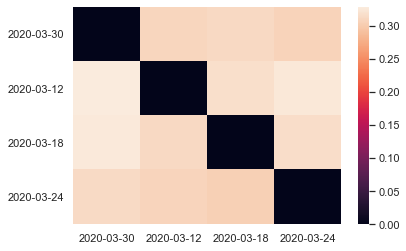

In [392]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(JS_Divergence(p,q))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


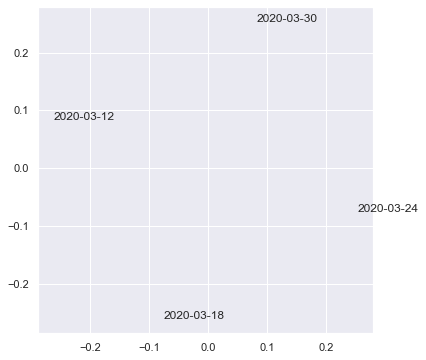

In [393]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

It looks like KS and JS divergence show very similar result. However, according to wikipedia, there seems to be notable differences such as being symmetric and always having a finite value.